In [1]:
# Geospatial data processing
import numpy as np
import geopandas as gpd
import networkx as nx
from shapely import Point


# Mapping and visualization
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D


# Network analysis
#import osmnx as ox

# The star of the show: city2graph for transportation network analysis
import city2graph

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.style.use('ggplot')
#plt.style.use('default')  # Clean default style instead of ggplot

print("All dependencies loaded successfully!")
print(f"city2graph version: {city2graph.__version__ if hasattr(city2graph, '__version__') else 'development'}")

All dependencies loaded successfully!
city2graph version: 0.1.6


# 1. Baixar dados Overture Maps

O código abaixo, faz o download dos dados, por tipo, mais recentes a partir de BBOX (longMax,latMax,longMin,atMin) ou de um Polígono.

In [2]:
# Carregar arquivos de referência da pesquisa
bbox_ae = [-42.865397,-5.231538,-42.662587,-4.955767] # Teresina city centre bounding box
area_estudo = gpd.read_file("dados/zona_urbana/area_estudo_zu.geojson", columns=["fid_ae", "geometry"]).to_crs(epsg=31983)
area_estudo_buffer3km = gpd.read_file("dados/zona_urbana/area_estudo_buffer3km_zu_utm.geojson", columns=["fid_ae", "geometry"]).to_crs(epsg=31983)

area_estudo.insert(loc=len(area_estudo.columns) - 1, column="area_m2", value=area_estudo.area)
area_estudo.insert(loc=len(area_estudo.columns) - 1, column="area_km2", value=area_estudo.area / 1000000)

area_estudo_buffer3km.insert(loc=len(area_estudo_buffer3km.columns) - 1, column="area_m2", value=area_estudo_buffer3km.area)
area_estudo_buffer3km.insert(loc=len(area_estudo_buffer3km.columns) - 1, column="area_km2", value=area_estudo_buffer3km.area / 1000000)


#### Caso já tenha feito o download dos dados, pule a célula abaixo

In [ ]:
# Download data from Overture Maps (uncomment to download fresh data)
# This downloads building footprints, road segments, and connectors for Liverpool city centre

city2graph.load_overture_data(
    area=area_estudo_buffer3km,
    types=["segment", "building", "connector"],
    output_dir="./dados/overturemaps/",
    prefix="teresina_AE3km_script_",
    save_to_file=True,
    return_data=False
)

print("Data loading configuration complete")
print("To download fresh data, uncomment the city2graph.load_overture_data() call above")

#### Caso tenha pulado a célula acima, faça o carregamento dos dados armazenados localmente.

In [ ]:
# Load the downloaded GeoJSON files
# Convert to UTM 23 Sul Grade (EPSG:31983) for accurate distance calculations
buildings_gdf = gpd.read_file("./dados/overturemaps/intermediarios/teresina_bbox_script_building.geojson").to_crs(epsg=31983)
segments_gdf = gpd.read_file("./dados/overturemaps/teresina_bbox_script_segment.geojson").to_crs(epsg=31983)
connectors_gdf = gpd.read_file("./dados/overturemaps/teresina_bbox_script_connector.geojson").to_crs(epsg=31983)
ubs_gdf = gpd.read_file("./dados/semplam/ubs_zu.geojson").to_crs(epsg=31983)

print("✅ Dados Carregados com Sucesso!")
print("📊 Resumo do Conjunto de Dados:")

print(f"   • UBS: {len(ubs_gdf):,}")
print(f"   • Buildings: {len(buildings_gdf):,}")
print(f"   • Road segments: {len(segments_gdf):,}")
print(f"   • Connectors: {len(connectors_gdf):,}")
print("\n")
print("----------- SRC ORIGNAL -----------------")

print(f"   • Área de Estudo (ZU) -> CRS ORIGINAL: {area_estudo.crs}")
print(f"   • Área de Estudo (ZU Buffer 3 km) -> CRS ORIGINAL: {area_estudo_buffer3km.crs}")
print(f"   • UBS -> CRS ORIGINAL: {ubs_gdf.crs}")
print(f"   • BUILDING -> CRS ORIGINAL: {buildings_gdf.crs}")
print(f"   • SEGMENTS -> CRS ORIGINAL: {segments_gdf.crs}")
print(f"   • CONNECTORS -> CRS ORIGINAL: {connectors_gdf.crs}")

✅ Dados Carregados com Sucesso!
📊 Resumo do Conjunto de Dados:
   • UBS: 75
   • Buildings: 433,496
   • Road segments: 54,077
   • Connectors: 39,091
----------- SRC ORIGNAL -----------------
   • Área de Estudo (ZU) -> CRS ORIGINAL: EPSG:31983
   • Área de Estudo (ZU Buffer 3 km) -> CRS ORIGINAL: EPSG:31983
   • UBS -> CRS ORIGINAL: EPSG:31983
   • BUILDING -> CRS ORIGINAL: EPSG:31983
   • SEGMENTS -> CRS ORIGINAL: EPSG:31983
   • CONNECTORS -> CRS ORIGINAL: EPSG:31983


In [5]:
segments_gdf.head(3)

,id,version,sources,subtype,class,names,connectors,routes,subclass_rules,access_restrictions,level_rules,destinations,prohibited_transitions,rail_flags,road_surface,road_flags,speed_limits,width_rules,subclass,geometry
0,3fbedeb9-2fde-48fa-b73d-4ce98ca6d8a3,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",rail,standard_gauge,"{ ""primary"": ""Ferrovia Transnordestina"", ""comm...","[ { ""connector_id"": ""b16574d6-dad8-4c12-8dbf-b...",None,None,None,"[ { ""value"": 1, ""between"": [ 0.0, 0.0076383589...",None,None,"[ { ""values"": [ ""is_bridge"" ], ""between"": [ 0....",None,None,None,None,None,"LINESTRING (741318.351 9437513.182, 741314.222..."
1,effc0f97-d37e-42d0-9229-b1af5b811c78,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,path,None,"[ { ""connector_id"": ""58eb7281-f8e3-4887-8db6-7...",None,None,None,None,None,None,None,None,None,None,None,None,"LINESTRING (737321.302 9421468.061, 737187.935..."
2,0787c5cd-327e-4988-9a42-46b1b177d068,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,unclassified,None,"[ { ""connector_id"": ""327217e8-1201-49ca-9aba-6...",None,None,None,None,None,None,None,"[ { ""value"": ""unpaved"", ""between"": null } ]",None,None,None,None,"LINESTRING (738700.06 9421332.752, 738692.884 ..."


In [6]:
segments_gdf["connectors"]

0        [ { "connector_id": "b16574d6-dad8-4c12-8dbf-b...
1        [ { "connector_id": "58eb7281-f8e3-4887-8db6-7...
2        [ { "connector_id": "327217e8-1201-49ca-9aba-6...
3        [ { "connector_id": "77448d18-7862-4d4b-bb1f-d...
4        [ { "connector_id": "327217e8-1201-49ca-9aba-6...
                               ...                        
54072    [ { "connector_id": "84043e2d-d5ef-4ea2-a354-a...
54073    [ { "connector_id": "569ca78a-f654-4dd5-b38f-0...
54074    [ { "connector_id": "569ca78a-f654-4dd5-b38f-0...
54075    [ { "connector_id": "85932c6d-32c9-4f5d-a74a-3...
54076    [ { "connector_id": "60888e53-1deb-4ea7-be64-2...
Name: connectors, Length: 54077, dtype: object

In [7]:

connectors_gdf.head()

,id,version,sources,geometry
0,37cf3a2f-c798-4c97-b66d-e95b7be39d89,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (737120.948 9421346.489)
1,58eb7281-f8e3-4887-8db6-7f894da496d4,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (737321.302 9421468.061)
2,77448d18-7862-4d4b-bb1f-d15c86b50133,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (738494.288 9421391.665)
3,327217e8-1201-49ca-9aba-66253a3d245f,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (738700.06 9421332.752)
4,10c9bbfc-195f-488e-a046-c816f06b21f8,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (742875.108 9421337.183)


#### Plotando dados iniciais

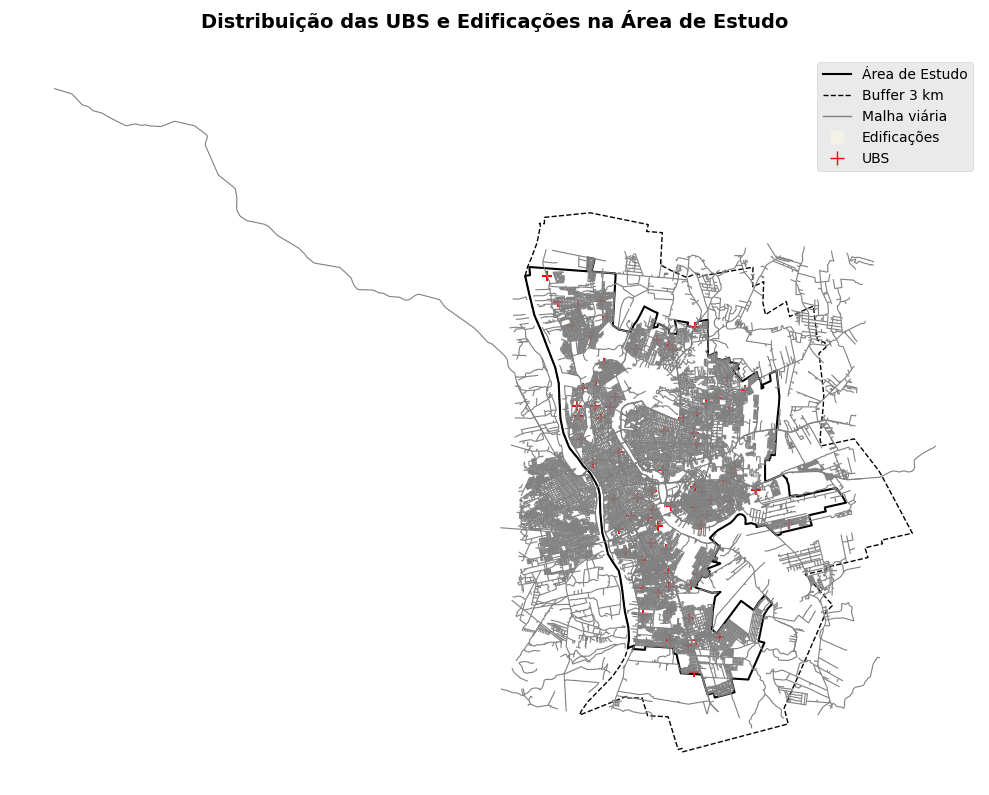

In [8]:
# --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Buildings — bege claro, sem contorno
#buildings_gdf.plot(ax=ax, facecolor='#f2f2e9', edgecolor='none', label='Edificações')

# 2️⃣ Malha viária — linhas cinza
segments_gdf.plot(ax=ax, color='gray', linewidth=0.8, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 4️⃣ Área de Estudo — contorno preto contínuo
area_estudo.plot(ax=ax, facecolor='none', edgecolor='black', 
                 linewidth=1.5, label='Área de Estudo')

# 5️⃣ UBS — cruz vermelha
ubs_gdf.plot(ax=ax, color='red', marker='+', markersize=50, label='UBS')

# --- Personalização do título e layout ---
ax.set_title("Distribuição das UBS e Edificações na Área de Estudo", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_axis_off()

# --- Legenda personalizada ---
custom_legend = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Área de Estudo'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Buffer 3 km'),
    Line2D([0], [0], color='gray', linewidth=1, label='Malha viária'),
    Line2D([0], [0], marker='s', color='#f2f2e9', markeredgecolor='none',
           markersize=10, label='Edificações', linestyle=''),
    Line2D([0], [0], marker='+', color='red', markersize=10, label='UBS', linestyle='')
]

ax.legend(handles=custom_legend, loc='upper right', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

# 2. Operação Espacial (Intersecção)
Como parte da organização da base de dados, irei realizar a operação espacial INTERSEÇAO para obter apenas as "pegadas de construções", segmentos e conectores dentro da zona urbana 3km

<Axes: >

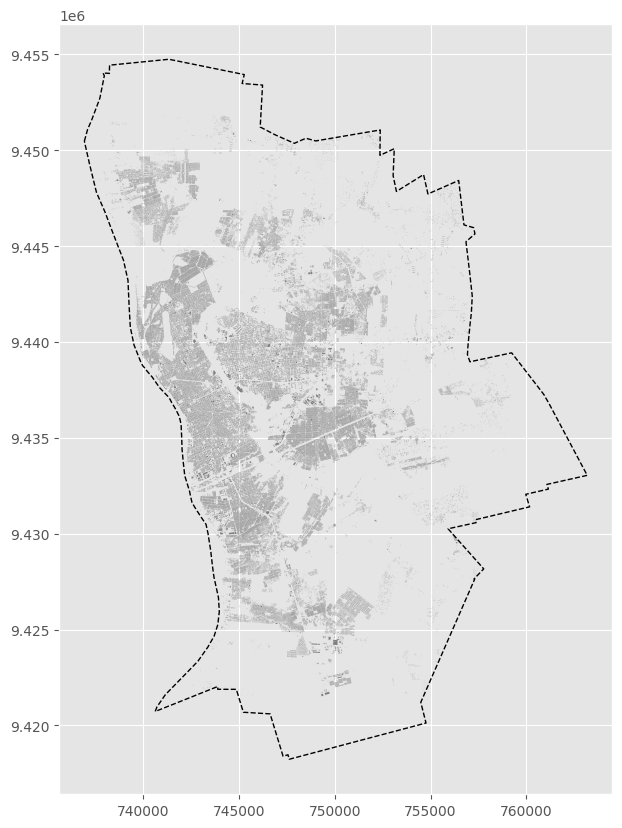

In [9]:
# Vamos realizar um operação espacial de interseção para obter apenas as vias dentro da zona urbana 3km
buildings_gdf_zu = buildings_gdf.overlay(area_estudo_buffer3km, how='intersection')

# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
buildings_gdf_zu.plot(ax=ax, color='gray', linewidth=0.2, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

In [10]:
buildings_gdf_zu.to_file(
    "dados/overturemaps/intermediarios/buildings_zu3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

In [ ]:
# Vamos realizar um operação espacial de interseção para obter apenas as vias dentro da zona urbana 3km
segments_gdf_zu = segments_gdf.overlay(area_estudo_buffer3km, how='intersection')

In [ ]:
# >>> INÍCIO DO NOVO CÓDIGO DE FILTRAGEM <<<
print(f"Número de segmentos de via antes da 1ª filtragem: {len(segments_gdf_zu)}")

# 1. PRIMEIRO FILTRO: Manter apenas subtype == 'road' (excluding pedestrian paths, railways, etc.)
segments_gdf_zu_step1 = segments_gdf_zu[segments_gdf_zu['subtype'] == 'road'].copy()
print(f"Número de segmentos após filtrar por subtype='road': {len(segments_gdf_zu_step1)}")


# 2. SEGUNDO FILTRO: Sobre o resultado anterior, filtrar pela classe da via
vias_para_manter = [
    'primary', 
    'secondary', 
    'tertiary', 
    'trunk', 
    'residential', 
    'unclassified'
]
# Filtra o GeoDataFrame do passo 1, mantendo apenas as classes desejadas
segments_gdf_zu_filter = segments_gdf_zu_step1[segments_gdf_zu_step1['class'].isin(vias_para_manter)].copy()

print(f"Número de segmentos após filtrar por 'class' (resultado final): {len(segments_gdf_zu_filter)}")

Número de segmentos de via antes da 1ª filtragem: 44969
Número de segmentos após filtrar por subtype='road': 44936
Número de segmentos após filtrar por 'class' (resultado final): 41025


<Axes: >

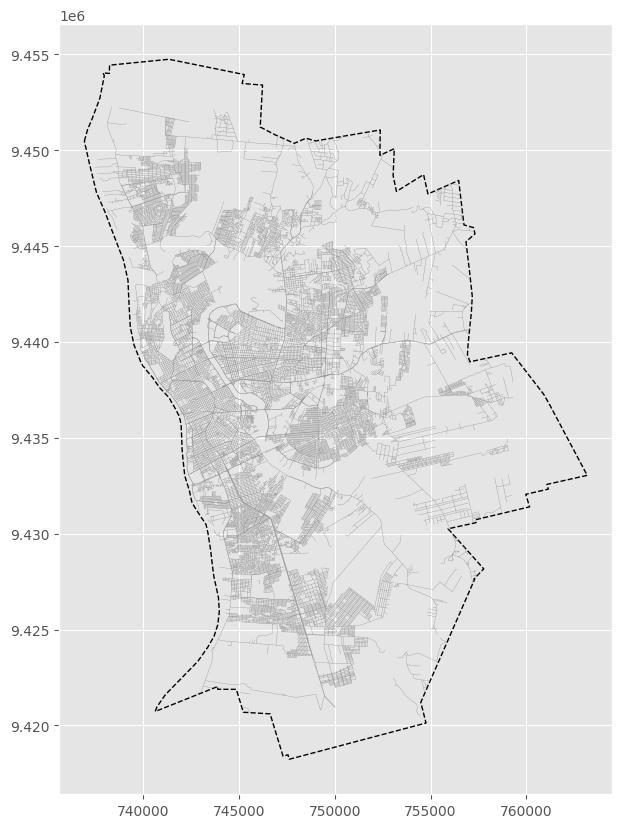

In [ ]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
segments_gdf_zu_filter.plot(ax=ax, color='gray', linewidth=0.2, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

In [ ]:
segments_gdf_zu_filter.to_file(
    "dados/overturemaps/connectors_zu3km_filter.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

In [17]:
# Vamos realizar um operação espacial de interseção para obter apenas as vias dentro da zona urbana 3km
connectors_gdf_zu_step1 = connectors_gdf.overlay(area_estudo_buffer3km, how='intersection')

<Axes: >

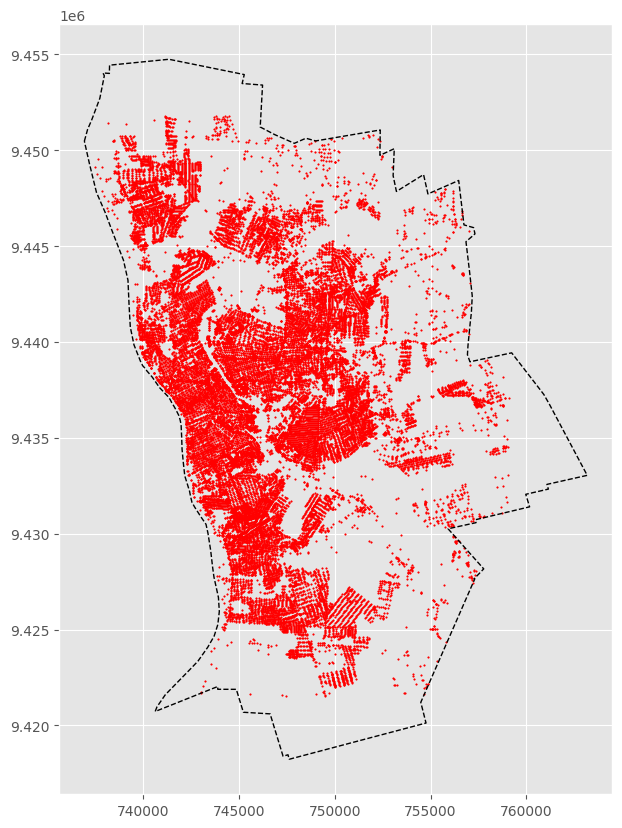

In [19]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
connectors_gdf_zu_step1.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

<Axes: >

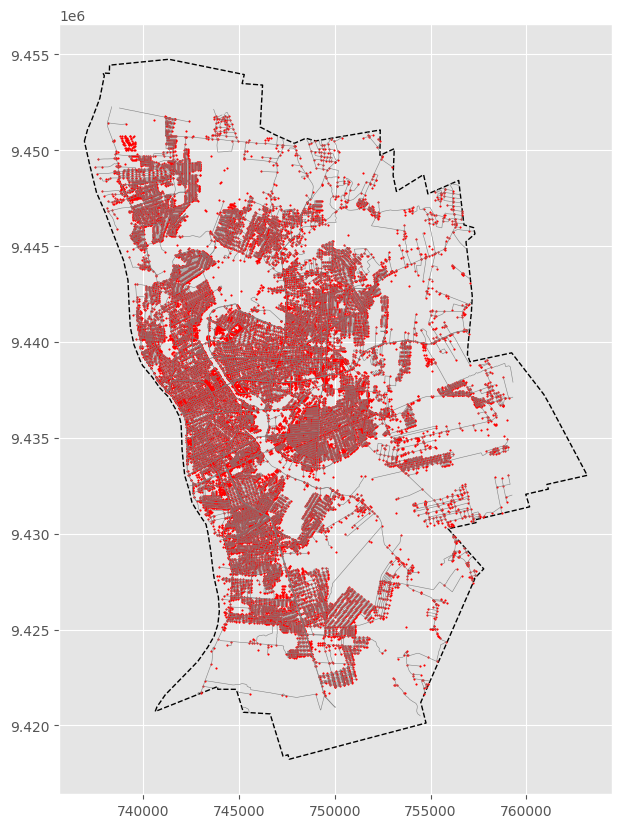

In [21]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
segments_gdf_zu_filter.plot(ax=ax, color='gray', linewidth=0.4, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 5️⃣ Conectores de Trechos de rua — círculo vermelho
connectors_gdf_zu_step1.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

Após a exclusão de alguns segmentos, alguns nó ficaram desconectados da rede. Necessário excluí-los.

In [ ]:
connectors_gdf_zu.to_file(
    "dados/overturemaps/connectors_zu3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

In [ ]:
buildings_gdf_3km = gpd.read_file("./dados/overturemaps/intermediarios/buildings_zu3km.geojson")
segments_gdf_3km = gpd.read_file("./dados/overturemaps/segments_zu3km_filter.geojson).to_crs(epsg=31983")
connectors_gdf_3km = gpd.read_file("./dados/overturemaps/connectors_zu3km_filter.geojson")

# 3. Street Network Processing

Before creating morphological graphs, we need to process the raw street data. This involves:

1. **Filtering**: Keep only road segments (exclude pedestrian paths, railways, etc.)
2. **Barrier Processing**: Handle bridges and tunnels to create accurate spatial barriers
3. **Network Cleanup**: Ensure proper connectivity for graph operations

The `barrier_geometry` column will contain the processed geometries that act as spatial barriers for tessellation.

In [ ]:
import pandas as pd
import json

# --- 1. Mapeamentos baseados no Código de Trânsito Brasileiro (CTB) ---

# Dicionário com as velocidades MÁXIMAS legais (em km/h)
speed_max_map_ctb = {
    'trunk': 80.0,        # Via de Trânsito Rápido
    'primary': 60.0,      # Via Arterial
    'secondary': 40.0,    # Via Coletora
    'tertiary': 40.0,     # Via Coletora
    'residential': 30.0,  # Via Local
    'unclassified': 30.0  # Via Local
}

# Dicionário com as velocidades MÍNIMAS legais (metade da máxima)
speed_min_map_ctb = {key: value / 2 for key, value in speed_max_map_ctb.items()}

# Dicionário com as velocidades MÉDIAS REALISTAS para modelagem
speed_avg_map_model = {
    'trunk': 50.0,
    'primary': 40.0,
    'secondary': 30.0,
    'tertiary': 25.0,
    'residential': 20.0,
    'unclassified': 20.0
}


# --- 2. Função para preencher os valores nulos em 'speed_limits' com dados do CTB ---
def preencher_limites_ctb(row):
    """
    Preenche 'speed_limits' nulos com os valores MÁXIMOS e MÍNIMOS do CTB.
    """
    if pd.isna(row['speed_limits']):
        road_class = row['class']
        
        # Pega os valores max e min dos nossos mapas CTB
        max_speed = speed_max_map_ctb.get(road_class, 30.0) # Default de 30 para segurança
        min_speed = speed_min_map_ctb.get(road_class, 15.0) # Default de 15
        
        data_structure = [{
            "min_speed": { "value": min_speed, "unit": "km\\/h" }, # Preenchendo min_speed
            "max_speed": { "value": max_speed, "unit": "km\\/h" },
            "is_max_speed_variable": None,
            "when": None,
            "between": None
        }]
        return json.dumps(data_structure)
    else:
        return row['speed_limits']

# --- 3. Aplicar a função para atualizar a coluna 'speed_limits' ---
print("Preenchendo 'speed_limits' com valores MÁX/MÍN do CTB...")
segments_gdf_zu['speed_limits'] = segments_gdf_zu.apply(preencher_limites_ctb, axis=1)
print("Coluna 'speed_limits' atualizada.")


# --- 4. Criar a nova coluna com a VELOCIDADE MÉDIA para modelagem ---
print("\nCriando coluna de velocidade média para modelagem...")
# A função .map() é uma forma muito eficiente de fazer isso
segments_gdf_zu['velocidade_media_kmh'] = segments_gdf_zu['class'].map(speed_avg_map_model)
# Preencher qualquer valor que não foi mapeado (caso haja uma 'class' inesperada)
segments_gdf_zu['velocidade_media_kmh'].fillna(20.0, inplace=True)
print("Coluna 'velocidade_media_kmh' criada.")


# --- 5. Calcular o TEMPO DE VIAGEM a partir da velocidade MÉDIA ---
print("\nCalculando o tempo de viagem a partir da velocidade média...")
# Converter a velocidade média para m/min
velocidade_mmin = segments_gdf_zu['velocidade_media_kmh'] * 1000 / 60
# Calcular o tempo de viagem em min
segments_gdf_zu['tempo_viagem_min'] = segments_gdf_zu.geometry.length / velocidade_mmin
print("Coluna 'tempo_viagem_min' criada e pronta para a análise de isócronas.")


# --- 6. Verificação Final ---
print("\nVerificação Final:")
# Contar nulos na coluna principal (esperado: 0)
print(f"Nulos em 'speed_limits': {segments_gdf_zu['speed_limits'].isna().sum()}")
# Contar nulos na coluna de velocidade média (esperado: 0)
print(f"Nulos em 'velocidade_media_kmh': {segments_gdf_zu['velocidade_media_kmh'].isna().sum()}")

print("\nAmostra do resultado final com as novas colunas:")
display(segments_gdf_zu[['class', 'speed_limits', 'velocidade_media_kmh', 'tempo_viagem_min']].sample(5))

# 2.1 Processamento dos Nó sem grafo

Após a filtrangem dos segmentos do tipo road e das class, algum nós ficaram sem aresta e devem ser  excluídos do conjunto

In [ ]:
import geopandas as gpd

# --- Pré-requisito: Garantir que ambos os GeoDataFrames tenham o mesmo CRS ---
# Se eles não tiverem o mesmo CRS, a operação falhará.
if connectors_gdf_zu.crs != segments_gdf_zu.crs:
    print("Aviso: Os CRS são diferentes. Projetando os nós para o CRS dos segmentos...")
    connectors_gdf_zu = connectors_gdf_zu.to_crs(segments_gdf_zu.crs)

# --- A Solução ---
print(f"Número de nós ANTES da limpeza: {len(connectors_gdf_zu)}")

# Realiza a junção espacial. Mantém apenas os nós que intersectam a rede de segmentos.
# how='inner': Só mantém os nós que encontram uma rua correspondente.
# predicate='intersects': A regra para a correspondência espacial.
connectors_gdf_zu_ok = gpd.sjoin(connectors_gdf_zu, segments_gdf_zu, how="inner", predicate="intersects")

# --- Limpeza Final ---
# A junção espacial adiciona colunas do GeoDataFrame de segmentos.
# Vamos remover duplicatas caso um nó toque mais de uma rua e manter apenas as colunas originais dos nós.
# Primeiro, obtemos o nome das colunas originais dos nós.
colunas_originais_nos = connectors_gdf_zu.columns

# Remove duplicatas de nós (baseado no índice original) e seleciona as colunas originais
connectors_gdf_zu_ok = connectors_gdf_zu_ok.drop_duplicates(subset='index_right').loc[:, colunas_originais_nos]


print(f"Número de nós APÓS a limpeza: {len(connectors_gdf_zu_ok)}")

# Agora, 'nos_conectados_gdf' contém apenas os pontos que estão conectados à sua rede filtrada.

## Check-Point dos dados: Salvar em arquivos físicos:

- segments_gdf_zu
- buildings_gdf_zu

In [ ]:
# Extra controle
# ===================================================================
# ===================================================================

# Exportar o GeoDataFrame para o formato GeoJSON
# É uma boa prática especificar a codificação para evitar problemas com caracteres especiais (acentos)
segments_gdf_zu.to_file(
    "dados/overturemaps/segments_zu3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

buildings_gdf_zu.to_file(
    "dados/overturemaps/intermediarios/buildings_zu3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

print("Arquivo GeoJSON salvo com sucesso")

In [ ]:
# Process segments to handle bridges/tunnels and create proper spatial barriers
segments_gdf_zu_barreiras = city2graph.process_overture_segments(
    segments_gdf=buildings_gdf_zu,
    get_barriers=True,
    connectors_gdf=connectors_gdf_zu,
    threshold=1.0
)

print(f"✅ Processed {len(segments_gdf_zu_barreiras)} road segments")
print("📈 Barrier geometries created for tessellation")

barriers = segments_gdf_zu_barreiras["barrier_geometry"]

# Check the geometry types in the barrier_geometry column
geometry_types = segments_gdf_zu_barreiras["barrier_geometry"].geom_type.value_counts()
print("\n🔍 Barrier geometry types:")
for geom_type, count in geometry_types.items():
    print(f"   • {geom_type}: {count:,}")

In [ ]:
barriers.plot()

In [ ]:
segments_gdf.head()

In [ ]:
# Extra controle
# ===================================================================
# ===================================================================

# Definir o nome do arquivo de saída
output_filename = 'dados/overturemaps/resultado/segments_road_filtrado.geojson'

# Exportar o GeoDataFrame para o formato GeoJSON
# É uma boa prática especificar a codificação para evitar problemas com caracteres especiais (acentos)
segments_gdf_filtrado1.to_file(
    output_filename, 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

print(f"Arquivo GeoJSON salvo com sucesso em: {output_filename}")

# 4. Creating Morphological Graphs

Now we’ll create the morphological graph - the core contribution of city2graph. This process:

![image.png](https://city2graph.net/_images/morph_net_process.png)

## The Process:

1. **Tessellation Creation**: Divide space into private areas using street segments as barriers
2. **Network Extraction**: Identify three types of spatial relationships:
    - Private-to-private (red): Adjacency between neighboring private spaces
    - Public-to-public (blue): Connectivity along street networks
    - Private-to-public (purple): Interface between private spaces and streets

## Why Morphological Graphs?

Unlike traditional approaches that analyze street networks and buildings separately, morphological graphs provide a **unified representation** of urban space that:

- Captures the complete topology of public and private spaces
- Enables holistic urban analysis combining street accessibility and land use
- Provides a foundation for spatially-explicit graph machine learning
- Supports integration of diverse urban attributes (POIs, demographics, functions)

In [ ]:
# Define center point for the analysis area (Centro da cidade de Teresina)
center_point = gpd.GeoSeries([Point(-5.08305465, -42.77597849)], crs='EPSG:4326').to_crs(epsg=31983)

# Garante que os índices sejam numéricos, simples e sequenciais
#buildings_gdf = buildings_gdf.reset_index(drop=True)
#segments_gdf = segments_gdf.reset_index(drop=True)

# Create the morphological graph
print("🏗️  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("✅ Morphological graph created successfully!")
print("📊 Network summary:")
print(f"   • Node types: {list(morpho_nodes.keys())}")
print(f"   • Edge types: {list(morpho_edges.keys())}")
print(f"   • Private spaces: {len(morpho_nodes['private']):,}")
print(f"   • Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   • {edge_type}: {len(edge_gdf):,} connections")

In [ ]:
morpho_nodes["private"].head()


In [ ]:
morpho_nodes["public"].head()


In [ ]:
morpho_edges[('public', 'connected_to', 'public')].head()


In [ ]:
morpho_edges[('private', 'faced_to', 'public')].head()


In [ ]:
morpho_edges[('private', 'touched_to', 'private')].head()


In [ ]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right',
frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()